In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'absolute'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0524545667063485 	 Validation loss: 1.9940728737136064 	 
  1%|          | 574/57400 [01:46<2:25:16,  6.52it/s]
Epoch 2 	 Training loss: 1.989700520080141 	 Validation loss: 1.9851264569718958 	 
  2%|▏         | 1148/57400 [03:25<2:15:45,  6.91it/s]
Epoch 3 	 Training loss: 1.9771610778798625 	 Validation loss: 1.990573329440618 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:05<2:36:23,  5.93it/s]
Epoch 4 	 Training loss: 1.9737271467152373 	 Validation loss: 1.977122444217488 	 
  4%|▍         | 2296/57400 [06:45<2:36:49,  5.86it/s]
Epoch 5 	 Training loss: 1.9696236985901092 	 Validation loss: 1.9719946020740573 	 
  5%|▌         | 2870/57400 [08:25<2:42:02,  5.61it/s]
Epoch 6 	 Training loss: 1.9653687865476575 	 Validation loss: 1.9657981294696614 	 
  6%|▌         | 3444/57400 [10:04<2:21:18,  6.36it/s]
Epoch 7 	 Training loss: 1.9625008388678786 	 Validation loss: 1.9732632960303356 	 

1 epoch without improvement
  7%|▋         | 4018

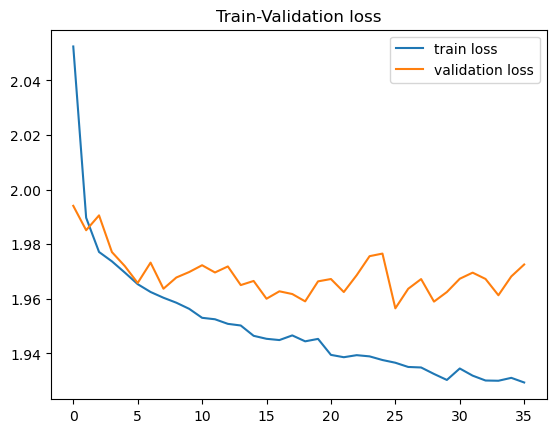

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_abs_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('roberta_multitask_abs_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}, 'as': {'recall': 0.7431551499348109, 'precision': 0.7431551499348109, 'f1': 0.7431551499348109, 'accuracy': 0.7431551499348109}, 'about': {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7396593673965937, 'precision': 0.7396593673965937, 'f1': 0.7396593673965937, 'accuracy': 0.7396593673965937}, 'as': {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7296587926509186, 'precision': 0.7296587926509186, 'f1': 0.7296587926509186, 'accuracy': 0.7296587926509186}, 'as': {'recall': 0.7520215633423181, 'precisio

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0651125712677163 	 Validation loss: 2.005660055047375 	 
  1%|          | 574/57400 [01:40<2:29:08,  6.35it/s]
Epoch 2 	 Training loss: 1.996617834950158 	 Validation loss: 1.9920317641759322 	 
  2%|▏         | 1148/57400 [03:19<2:44:09,  5.71it/s]
Epoch 3 	 Training loss: 1.9843037952944793 	 Validation loss: 1.9853617902529441 	 
  3%|▎         | 1722/57400 [04:56<2:33:31,  6.04it/s]
Epoch 4 	 Training loss: 1.9776618243925248 	 Validation loss: 1.9732467784719951 	 
  4%|▍         | 2296/57400 [06:36<2:14:27,  6.83it/s]
Epoch 5 	 Training loss: 1.9716537175278215 	 Validation loss: 1.9795670569953272 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:16<2:24:12,  6.30it/s]
Epoch 6 	 Training loss: 1.969232816729396 	 Validation loss: 1.9628004744901495 	 
  6%|▌         | 3444/57400 [09:55<2:26:59,  6.12it/s]
Epoch 7 	 Training loss: 1.9651670767455152 	 Validation loss: 1.9724740739596092 	 

1 epoch without improvement
  7%|▋         | 4018

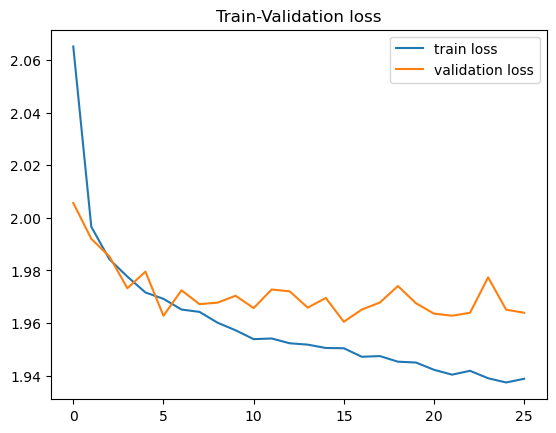

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_abs_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7095959595959596, 'precision': 0.7095959595959596, 'f1': 0.7095959595959596, 'accuracy': 0.7095959595959596}, 'as': {'recall': 0.7222946544980443, 'precision': 0.7222946544980443, 'f1': 0.7222946544980443, 'accuracy': 0.7222946544980443}, 'about': {'recall': 0.8418367346938775, 'precision': 0.8418367346938775, 'f1': 0.8418367346938774, 'accuracy': 0.8418367346938775}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7297979797979798, 'precision': 0.7297979797979798, 'f1': 0.7297979797979797, 'accuracy': 0.7297979797979798}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6797900262467191, 'precision': 0.6797900262467191, 'f1': 0.6797900262467191, 'accuracy': 0.6797900262467191}, 'a

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0413248079994415 	 Validation loss: 1.9930260989625574 	 
  1%|          | 574/57400 [01:37<2:24:28,  6.56it/s]
Epoch 2 	 Training loss: 1.9899265961364587 	 Validation loss: 1.982152209443561 	 
  2%|▏         | 1148/57400 [03:16<2:16:48,  6.85it/s]
Epoch 3 	 Training loss: 1.98139080000256 	 Validation loss: 1.9799775269071935 	 
  3%|▎         | 1722/57400 [04:54<2:29:34,  6.20it/s]
Epoch 4 	 Training loss: 1.9727605973801963 	 Validation loss: 1.9831221285512892 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:31<2:50:16,  5.39it/s]
Epoch 5 	 Training loss: 1.9702694590498762 	 Validation loss: 1.9745794979192444 	 
  5%|▌         | 2870/57400 [08:09<2:23:39,  6.33it/s]
Epoch 6 	 Training loss: 1.969140046149596 	 Validation loss: 1.9725353051040133 	 
  6%|▌         | 3444/57400 [09:47<2:22:19,  6.32it/s]
Epoch 7 	 Training loss: 1.964547675453412 	 Validation loss: 1.9737059605323661 	 

1 epoch without improvement
  7%|▋         | 4018/5

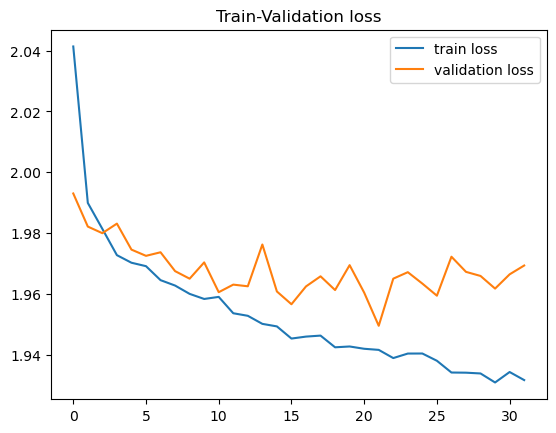

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_abs_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7272727272727273, 'precision': 0.7272727272727273, 'f1': 0.7272727272727273, 'accuracy': 0.7272727272727273}, 'as': {'recall': 0.7444589308996089, 'precision': 0.7444589308996089, 'f1': 0.7444589308996089, 'accuracy': 0.7444589308996089}, 'about': {'recall': 0.8482142857142857, 'precision': 0.8482142857142857, 'f1': 0.8482142857142857, 'accuracy': 0.8482142857142857}} 

Evaluación en etiquetas male
{'to': {'recall': 0.732360097323601, 'precision': 0.732360097323601, 'f1': 0.732360097323601, 'accuracy': 0.732360097323601}, 'as': {'recall': 0.7424242424242424, 'precision': 0.7424242424242424, 'f1': 0.7424242424242424, 'accuracy': 0.7424242424242424}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7217847769028871, 'precision': 0.7217847769028871, 'f1': 0.7217847769028871, 'accuracy': 0.7217847769028871}, 'as': {'recall': 0.7466307277628033, 'precision': 

In [17]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8452380952380952, 'precision': 0.8452380952380952, 'f1': 0.8452380952380952, 'accuracy': 0.8452380952380952}
Métricas etiqueta male: {'recall': 0.8454861111111112, 'precision': 0.8454861111111112, 'f1': 0.8454861111111112, 'accuracy': 0.8454861111111112}
Métricas etiqueta female:  {'recall': 0.845, 'precision': 0.845, 'f1': 0.845, 'accuracy': 0.845}

 to
Resultado global: {'recall': 0.7239057239057239, 'precision': 0.7239057239057239, 'f1': 0.7239057239057238, 'accuracy': 0.7239057239057239}
Métricas etiqueta male: {'recall': 0.7364152473641524, 'precision': 0.7364152473641524, 'f1': 0.7364152473641524, 'accuracy': 0.7364152473641524}
Métricas etiqueta female:  {'recall': 0.710411198600175, 'precision': 0.710411198600175, 'f1': 0.710411198600175, 'accuracy': 0.710411198600175}

 as
Resultado global: {'recall': 0.7366362451108214, 'precision': 0.7366362451108214, 'f1': 0.7366362451108214, 'accuracy': 0.7366362451108214}
Métrica